# Simulacion Robot Escar 3gdl

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from celluloid import Camera
import trimesh

### Clase anotacion 3d, permite colocar texto en 3d

In [2]:
from matplotlib.text import Annotation
class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

## Grafica lineas en 3D

In [ ]:
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, xe, ye, ze, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (xs, ys, zs)
        self._dxdydz = (xe-xs, ye-ys, ze-zs)

    def draw(self, renderer):
        xs, ys, zs = self._xyz
        dx, dy, dz = self._dxdydz
        xe, ye, ze = (xs + dx, ys + dy, zs + dz)

        xs, ys, zs = proj_transform(xs, ys, zs, self.axes.M)
        xe, ye, ze = proj_transform(xe, ye, ze, self.axes.M)
        self.set_positions((xs,ys), (xe,ye))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)
    
def _arrow3D(ax, xs, ys, zs, xe, ye, ze, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(xs, ys, zs, xe, ye, ze, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

## Rotaciones

In [3]:
def MTHRotx(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(angulo), -np.sin(angulo), 0],
                     [0, np.sin(angulo), np.cos(angulo), 0],
                     [0, 0, 0, 1]])

def MTHRoty(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[np.cos(angulo), 0, np.sin(angulo), 0],
                     [0, 1, 0, 0],
                     [-np.sin(angulo), 0, np.cos(angulo), 0],
                     [0, 0, 0, 1]])

def MTHRotz(angulo):
    #Matriz de transformación homogenea, se usa la conversion de grados a radianes.
    return np.array([[np.cos(angulo), -np.sin(angulo), 0, 0],
                     [np.sin(angulo), np.cos(angulo), 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])



## Traslaciiones

In [4]:
def MTHtrasx(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[0, 3] = distancia
    return MTH

def MTHtrasy(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[1, 3] = distancia
    return MTH

def MTHtrasz(distancia):
    # Crear una matriz de transformación homogénea identidad 4x4
    MTH = np.eye(4)
    # Asignar la distancia a la posición en el eje x (fila 1, columna 4)
    MTH[2, 3] = distancia
    return MTH

# Cinematica directa de un robot SCARA

In [5]:
def SCARA_cin_dir(q):
    # Medidas principales del robot
    L1 = 400
    L2 = 562.5
    L3 = 437.5
    G1 = 50
    A03 = MTHRotz(q[0]) @ MTHRotz(q[1])
    Px = L2 * np.cos(q[0]) + L3 * np.cos(q[0] + q[1])
    Py = L2 * np.sin(q[0]) + L3 * np.sin(q[0] + q[1])
    Pz = L1 + G1 - q[2]
    A03[0:3, 3] = [Px, Py, Pz]
    return A03

In [6]:
q = np.array([np.pi/2, -np.pi/2, 0])
SD = SCARA_cin_dir(q)
SD

array([[  1. ,   0. ,   0. , 437.5],
       [  0. ,   1. ,   0. , 562.5],
       [  0. ,   0. ,   1. , 450. ],
       [  0. ,   0. ,   0. ,   1. ]])

## Dibujar sitema de referencia

In [7]:
def dibujar_sistema_referencia_MTH(MTH, L, subindice, ax=None):
    #Esta funcion grafica un sistema de referencia a partir de una matriz de transformacion homogenea.
    
    #Puntos finales de los ejes x, y, z
    pfx = MTH @ np.array([[L], [0], [0], [1]])
    pfy = MTH @ np.array([[0], [L], [0], [1]])
    pfz = MTH @ np.array([[0], [0], [L], [1]])
    
    #Origen
    origen = np.array([MTH[0, 3], MTH[1, 3], MTH[2, 3]])
    
    #Crear figura y objeto de eje si no se proporciona uno
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        

    #Dibujar los ejes
    #ax.arrow3D(origen[0], origen[1], origen[2], pfx[0, 0], pfx[1, 0], pfx[2, 0], mutation_scale=100, arrowstyle="-", linestyle='solid', color='red')
    #ax.arrow3D(origen[0], origen[1], origen[2], pfy[0, 0], pfy[1, 0], pfy[2, 0], mutation_scale=100, arrowstyle="-", linestyle='solid', color='green')
    #ax.arrow3D(origen[0], origen[1], origen[2], pfz[0, 0], pfz[1, 0], pfz[2, 0], mutation_scale=100, arrowstyle="-", linestyle='solid', color='blue')
    ax.plot([origen[0] ,pfx[0, 0]],[origen[1],pfx[1, 0]],[origen[2],pfx[2, 0]], color = 'r')
    ax.plot([origen[0] ,pfy[0, 0]],[origen[1],pfy[1, 0]],[origen[2],pfy[2, 0]], color = 'g')
    ax.plot([origen[0] ,pfz[0, 0]],[origen[1],pfz[1, 0]],[origen[2],pfz[2, 0]], color = 'b')
    
    #Agregar texto al final de los ejes
    subindicex = 'x'+subindice
    subindicey = 'y'+subindice
    subindicez = 'z'+subindice

    ax.annotate3D(subindicex, (pfx[0, 0], pfx[1, 0], pfx[2, 0]), xytext=(3, 3), textcoords='offset points')
    ax.annotate3D(subindicey, (pfy[0, 0], pfy[1, 0], pfy[2, 0]), xytext=(3, 3), textcoords='offset points')
    ax.annotate3D(subindicez, (pfz[0, 0], pfz[1, 0], pfz[2, 0]), xytext=(3, 3), textcoords='offset points')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.grid(True)


<IPython.core.display.Javascript object>


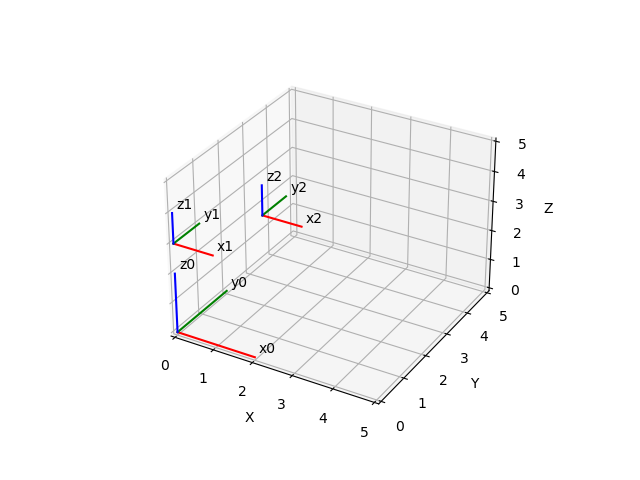

<function matplotlib.pyplot.show(*, block=None)>

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
MTH = np.array([[1., 0., 0., 1.], [0., 1., 0., 2.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
dibujar_sistema_referencia_MTH(MTH, 1, '2', ax)
MTH = np.array([[1., 0., 0., 0.], [0., 1., 0., 0.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
dibujar_sistema_referencia_MTH(MTH, 1,'1', ax)
dibujar_sistema_referencia_MTH(np.eye(4), 2, '0', ax)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_zlim(0,5)
plt.show
#X_rojo
#Y_verde
#Z_Azul

In [9]:
MTH = MTHtrasz(3)@np.array([[1., 0., 0., 1.], [0., 1., 0., 2.],[0., 0., 1., 3.],[0., 0., 0., 1.]])
MTH

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 6.],
       [0., 0., 0., 1.]])

# Traslacion Premultiplicación

<IPython.core.display.Javascript object>


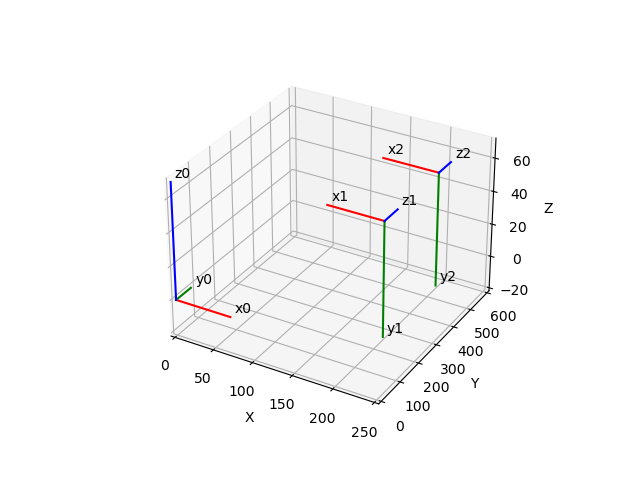

(-20.0, 70.0)

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
A00 = np.eye(4)
A01 = np.array([[-1., 0., 0.,200.],[0., 0., 1.,250.],[0.,-1.,0.,50.],[0.,0.,0.,1]])
A02 = MTHtrasy(300)@A01
dibujar_sistema_referencia_MTH(A00, 70, '0', ax)
dibujar_sistema_referencia_MTH(A01, 70, '1', ax)
dibujar_sistema_referencia_MTH(A02, 70, '2', ax)
ax.set_xlim(0,250)
ax.set_ylim(0,600)
ax.set_zlim(-20,70)

# Traslacion Posmultiplicación

<IPython.core.display.Javascript object>


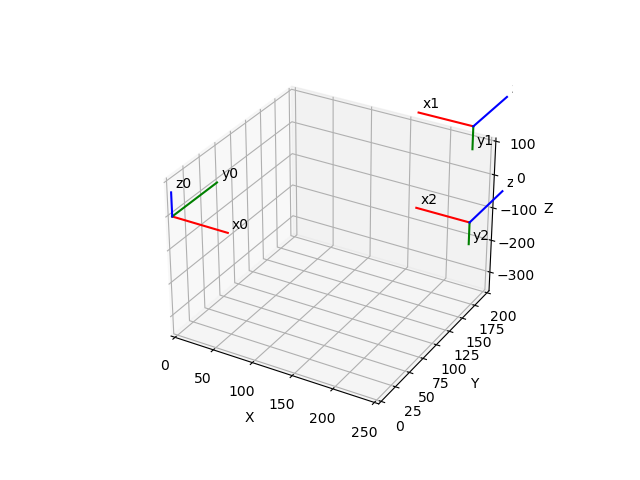

(-350.0, 100.0)

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
A00 = np.eye(4)
A01 = np.array([[-1., 0., 0.,200.],[0., 0., 1.,250.],[0.,-1.,0.,50.],[0.,0.,0.,1]])
A02 = A01@MTHtrasy(300)
dibujar_sistema_referencia_MTH(A00, 70, '0', ax)
dibujar_sistema_referencia_MTH(A01, 70, '1', ax)
dibujar_sistema_referencia_MTH(A02, 70, '2', ax)
ax.set_xlim(0,250)
ax.set_ylim(0,200)
ax.set_zlim(-350,100)

Premultiplicacion, Se traslada respecto al origen figo.

Postmultiplicació, se traslada respecto al propio sistema de referencia.

# Premultiplicación: Rotación

<IPython.core.display.Javascript object>


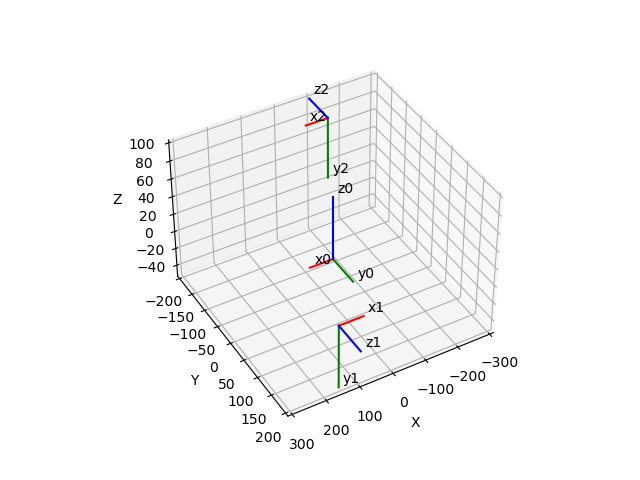

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
A00 = np.eye(4)
A01 = np.array([[-1., 0., 0.,200.],[0., 0., 1.,250.],[0.,-1.,0.,50.],[0.,0.,0.,1]])
A02 = MTHRotz(np.pi)@A01
dibujar_sistema_referencia_MTH(A00, 70, '0', ax)
dibujar_sistema_referencia_MTH(A01, 70, '1', ax)
dibujar_sistema_referencia_MTH(A02, 70, '2', ax)
ax.set_xlim(-300,300)
ax.set_ylim(-200,200)
ax.set_zlim(-50,100)
ax.view_init(40,60)
plt.show()

# Postmultiplicación: Rotación

<IPython.core.display.Javascript object>


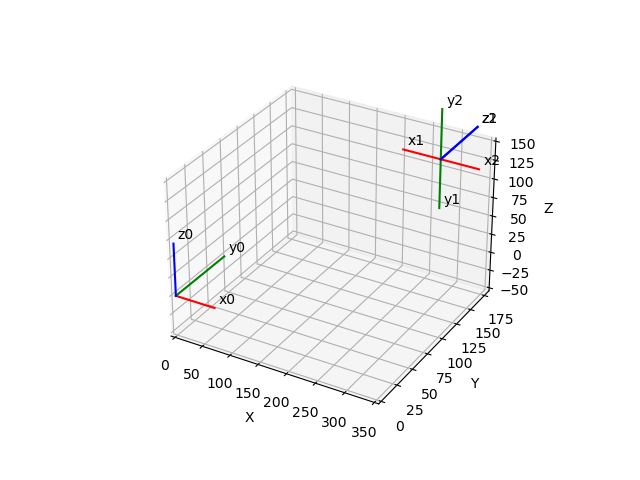

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
A00 = np.eye(4)
A01 = np.array([[-1., 0., 0.,200.],[0., 0., 1.,250.],[0.,-1.,0.,50.],[0.,0.,0.,1]])
A02 = A01@MTHRotz(np.pi)
dibujar_sistema_referencia_MTH(A00, 70, '0', ax)
dibujar_sistema_referencia_MTH(A01, 70, '1', ax)
dibujar_sistema_referencia_MTH(A02, 70, '2', ax)
ax.set_xlim(0,350)
ax.set_ylim(0,180)
ax.set_zlim(-50,150)
#ax.view_init(40,60)
plt.show()

Al igual que la traslacion, premultiplicacion respecto al origen, y postmultiplicación respecto al cual se quiere rotar.

# Concatenacion de matrice de transformación homogenea.

1. Traslación	a	lo	largo	del	eje	x	fijo	250	unidades	
2. Rotación	alrededor	del	eje	z	fijo	un	ángulo	de	180	grados	
3. Traslación	a	lo	largo	del	eje	y	móvil	400	unidades	

<IPython.core.display.Javascript object>


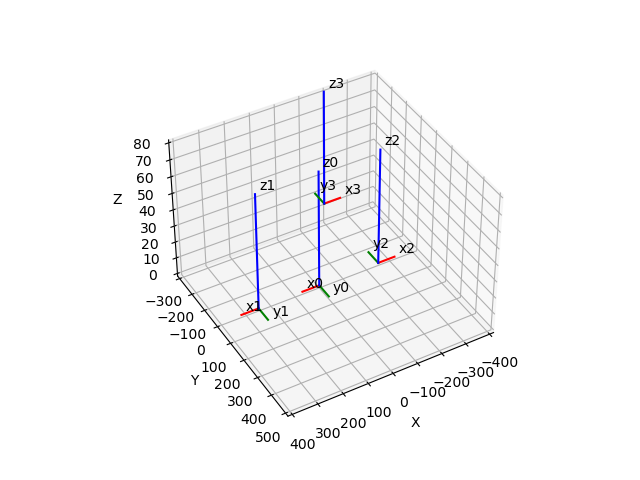

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
A00 = np.eye(4)
A01 = MTHtrasx(250)@A00
A02 = MTHRotz(np.pi)@A01
A32 = A02@MTHtrasy(400)
dibujar_sistema_referencia_MTH(A00, 70, '0', ax)
dibujar_sistema_referencia_MTH(A01, 70, '1', ax)
dibujar_sistema_referencia_MTH(A02, 70, '2', ax)
dibujar_sistema_referencia_MTH(A32, 70, '3', ax)
ax.set_xlim(-400,400)
ax.set_ylim(-300,500)
ax.set_zlim(0,80)
ax.view_init(40,60)
plt.show()

# Animacion

## Traslación respecto al eje z movil

<IPython.core.display.Javascript object>


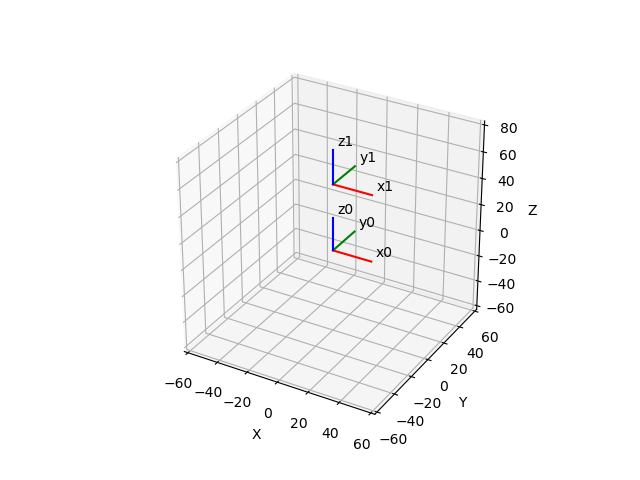

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_zlim(-60,80)

camera = Camera(fig)  # Crear un objeto Camera para almacenar las imágenes.

A00 = np.eye(4)
dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
camera.snap()

for i in range(0, 51, 2):
    A01 = MTHtrasz(i) @ A00
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    camera.snap()

animation = camera.animate(interval=100, blit = True, repeat=False)  # Crear la animación a partir de las imágenes almacenadas en la cámara. Blit muestra solo las graficas que han cambiado para acelerar la animacción

plt.show()


## Traslación respecto al eje z movil y luego respecto a su eje x movil221

<IPython.core.display.Javascript object>


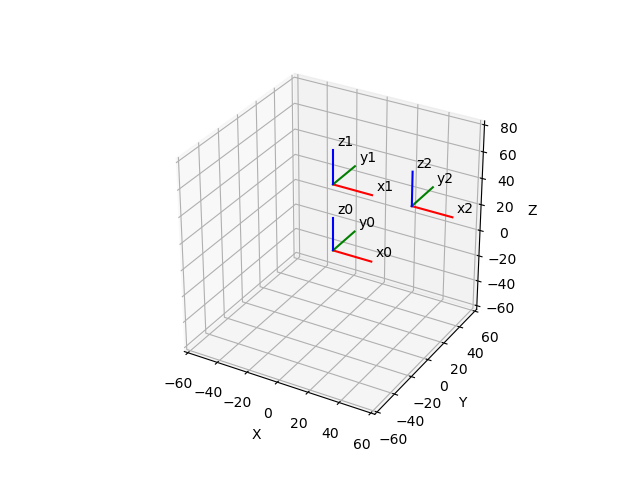

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_zlim(-60,80)

camera = Camera(fig)  # Crear un objeto Camera para almacenar las imágenes.

A00 = np.eye(4)
dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
camera.snap()

#Respecto al eje z mfijo
for i in range(0, 51, 2):
    A01 = MTHtrasz(i) @ A00
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    camera.snap()
    
for i in range(0, 51, 2):
    A12 = A01@MTHtrasx(i)
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    dibujar_sistema_referencia_MTH(A12, 25, '2', ax)
    camera.snap()

animation = camera.animate(interval=100, blit = True, repeat=False)  # Crear la animación a partir de las imágenes almacenadas en la cámara. Blit muestra solo las graficas que han cambiado para acelerar la animacción

plt.show()

## Traslación respecto al eje z fijo, luego traslación respecto al eje x movil y luego una rotación respecto al eje x movil

<IPython.core.display.Javascript object>


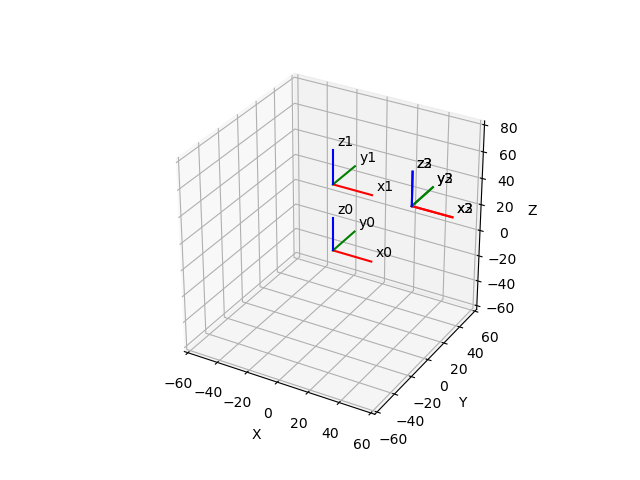

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_zlim(-60,80)

camera = Camera(fig)  # Crear un objeto Camera para almacenar las imágenes.

A00 = np.eye(4)
dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
camera.snap()

#Respecto al eje z mfijo
for i in range(0, 51, 2):
    A01 = MTHtrasz(i) @ A00
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    camera.snap()
    
for i in range(0, 51, 2):
    A12 = A01@MTHtrasx(i)
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    dibujar_sistema_referencia_MTH(A12, 25, '2', ax)
    camera.snap()

for theta in np.linspace(0, 2*np.pi, num=20):
    A23 = A12@MTHRotx(theta)
    dibujar_sistema_referencia_MTH(A00, 25, '0', ax)
    dibujar_sistema_referencia_MTH(A01, 25, '1', ax)
    dibujar_sistema_referencia_MTH(A12, 25, '2', ax)
    dibujar_sistema_referencia_MTH(A23, 25, '3', ax)
    camera.snap()

animation = camera.animate(interval=100, blit = True, repeat=False)  # Crear la animación a partir de las imágenes almacenadas en la cámara. Blit muestra solo las graficas que han cambiado para acelerar la animacción

plt.show()

# Usar trimesh para cargar un archivo stl.

<IPython.core.display.Javascript object>


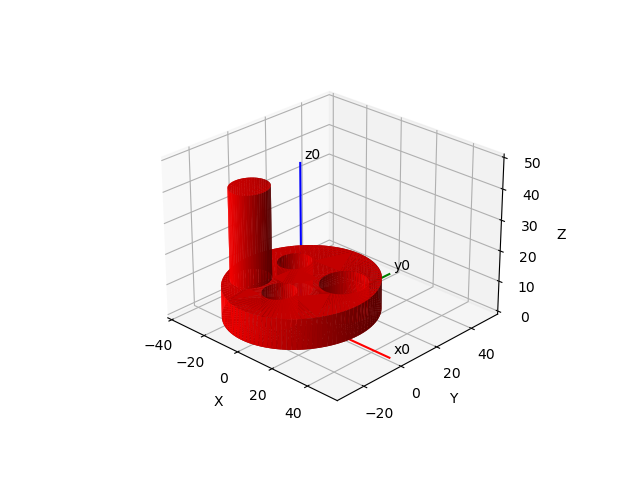

In [24]:
# Cargar la malla desde un archivo STL
objeto = trimesh.load_mesh('fig3d1.stl')
# Establece la opacidad del material
objeto.visual.face_colors = [255, 255, 255, 128]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Obtener vértices y caras de la malla
vertices = objeto.vertices
faces = objeto.faces

# Agregar la malla al gráfico
ax.plot_trisurf(objeto.vertices[:, 0], objeto.vertices[:, 1], objeto.vertices[:, 2], triangles=malla.faces, color='red')
# Dibujar sistema de referencia
dibujar_sistema_referencia_MTH(A00, 50, '0', ax)

plt.show()

# Moviendo el archivo stl con matrices de transformacion homogenea.

<IPython.core.display.Javascript object>


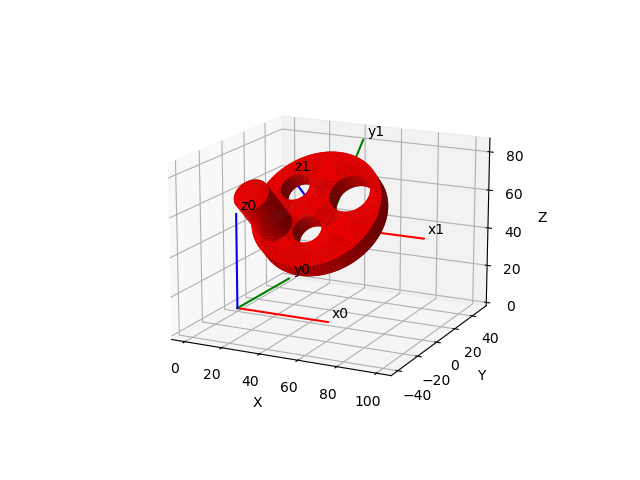

In [31]:
# Cargar la malla desde un archivo STL
objeto = trimesh.load_mesh('fig3d1.stl')
# Establece la opacidad del material
objeto.visual.face_colors = [255, 255, 255, 128]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Obtener vértices y caras de la malla
vertices = objeto.vertices
faces = objeto.faces

# Agregar la malla al gráfico
#ax.plot_trisurf(objeto.vertices[:, 0], objeto.vertices[:, 1], objeto.vertices[:, 2], triangles=malla.faces, color='red')
# Dibujar sistema de referencia
dibujar_sistema_referencia_MTH(A00, 50, '0', ax)

#Traslación
A = MTHtrasz(50)@MTHtrasx(50)@MTHRotx(np.pi/4)
dibujar_sistema_referencia_MTH(A, 50, '1', ax)
transformed_vertices = trimesh.transform_points(vertices, A)
#print(T)

#Dibujar nuevamente el archivo movido

ax.plot_trisurf(transformed_vertices[:, 0], transformed_vertices[:, 1], transformed_vertices[:, 2],
                    triangles=faces, color='red', edgecolor='None')

plt.show()